# **Introduction to Option Greeks**

In options trading, **Greeks** are key risk measures that describe how the price of an option responds to changes in market variables, such as the underlying asset’s price, volatility, time, or interest rates.

They are partial derivatives of the option pricing model, and are essential for:
- Understanding price sensitivity
- Managing risk exposures
- Designing hedging strategies

In this notebook, we compute and visualize several Greeks using the **Black–Scholes model**, combining both closed-form expressions and **finite difference methods (FDM)** where needed.

1. [Low-Order Greeks](#log)
    - 1.0.[Black & Scholes Set Up](#bs)
    - 1.1[Delta](#delta)
    - 1.2[Gamma](#gamma)
    - 1.3[Vega](#vega)
    - 1.4[Theta](#theta)
    - 1.5[Rho](#rho)

2. [High-Order Greeks](#hog)
    - 2.1.[Finite Difference Approximation](#fdm)
    - 2.2.[Vanna](#vanna)
    - 2.3.[Volga](#volga)
    - 2.4.[Charm](#Charm)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

---

<a id='log'></a>
# **1. Low-Order Greeks**

This section introduces the five primary low-order Greeks used in options trading. These represent first-order and second-order sensitivities of an option's price to various market inputs.

We will use the **Black–Scholes model** to compute these sensitivities, both through closed-form formulas and (later) numerical methods such as finite differences.

In [3]:
K = 100.0
sigma = 0.3
r = 0.02

n = 100
S_arr = np.linspace(20.0, 180, n)
T_arr = np.linspace(0.1, 1.0, n)

S_grid, T_grid = np.meshgrid(S_arr, T_arr)

def plot_greek_surface(S_grid, T_grid, greek_grid, greek_name, elev=30, azim=280):
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(
        S_grid, T_grid, greek_grid,
        cmap='jet',
        edgecolor='k',
        linewidth=0.3,
        antialiased=True
    )
    cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10)
    cbar.set_label(f'{greek_name}', rotation=270, labelpad=15)

    ax.set_title(f'{greek_name} Surface', fontsize=14, y=1.02)
    ax.set_xlabel('Spot Price (S)', labelpad=10)
    ax.set_ylabel('Time to Maturity (T)', labelpad=10)
    ax.set_zlabel(f'{greek_name}', labelpad=10)

    ax.view_init(elev=elev, azim=azim)

    plt.tight_layout()
    plt.show()

<a id='bs'></a>
## **1.0 Black–Scholes Model Setup**

To compute Greeks, we begin with the Black–Scholes model for European option pricing:

$$
C_0 = S_0 \cdot N(d_1) - K e^{-rT} \cdot N(d_2)
$$

$$
d_1 = \frac{\ln(S_0/K) + (r + \frac{\sigma^2}{2})T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T}
$$

Below is a reusable Python function to compute the price of a European call or put option:

In [ ]:
def bs_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Not a valid option type, type must be 'call' or 'put'")

<a id='delta'></a>
## **1.1 Delta**

- **Definition**: Measures sensitivity of the option price to changes in the underlying asset price.
- **Formula**:
  $$
  \Delta_{\text{call}} = N(d_1), \ \Delta_{\text{put}} = N(d_1) - 1
  $$
- Used for: **Delta hedging**, directional exposure control.

- **Risk**: If the underlying moves significantly, the position gains delta (not just vega).

- **Solution**:
  - Delta-hedge dynamically using the underlying:
  - If underlying goes up, sell shares to stay delta-neutral
  - If it drops, buy shares
  - Can use delta-neutral rebalancing every X hours/days

This is part of gamma scalping, but for vega traders it’s just to keep delta flat while waiting for IV to rise.

- **Model Risk**:
  - You rely on a model to compute delta (usually Black-Scholes or similar).
  - If your model assumptions are wrong (e.g., volatility not constant, jump risk ignored), your delta estimates are off.

In [ ]:
def bs_delta(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return norm.cdf(d1)
    elif option_type == 'put':
        return norm.cdf(d1) - 1
    else:
        raise ValueError("Not a valid option type, type must be 'call' or 'put'")

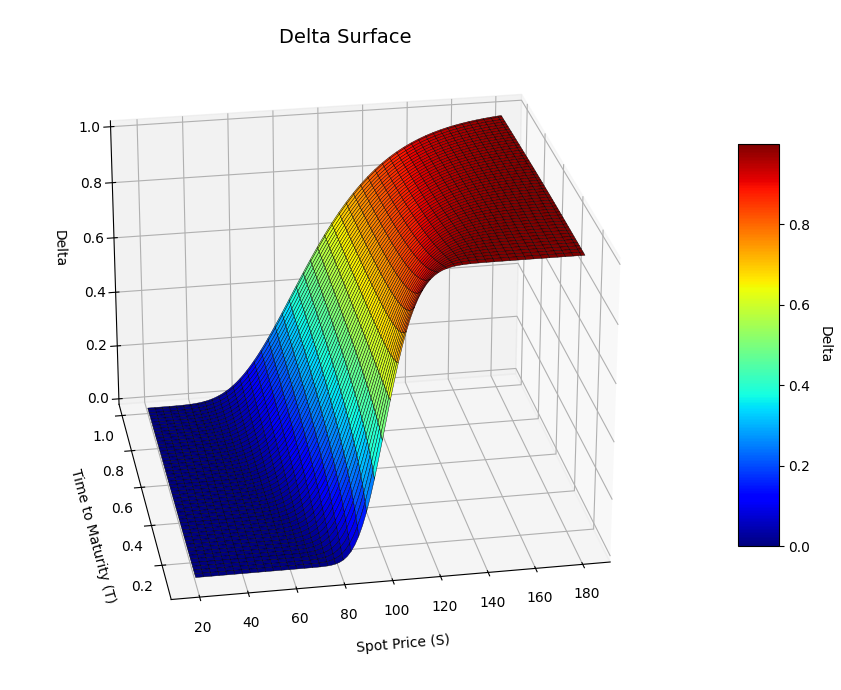

In [6]:
delta_grid = bs_delta(S_grid, K, T_grid, r, sigma)
plot_greek_surface(S_grid, T_grid, delta_grid, "Delta", elev=25, azim=260)

As time to maturity approaches zero, Delta increasingly resembles a **Heaviside step function**, with a sharp discontinuity at-the-money. This behavior makes delta hedging highly unstable and costly near expiry, particularly for at-the-money options.

<a id='gamma'></a>
## **1.2 Gamma (Curvature Risk)**

- **Definition**: Measures the rate of change of delta with respect to the underlying price.
- **Formula**:
  $$
  \Gamma_{call} = \Gamma_{put} = \frac{N'(d_1)}{S \sigma \sqrt{T}}
  $$

- Used for: Understanding convexity; **gamma scalping** strategies.


Risk: You’re long gamma → your delta will change a lot as price moves → introduces more hedging costs.

Solution (Partial):
- Accept small gamma exposure
- Or:
	- Use slightly OTM options instead of ATM to reduce gamma
	- Balance with short gamma legs, e.g., long strangle + short further OTM legs (broken-wing straddle)

Gamma is hard to neutralize without giving up vega, so it’s often tolerated, unless you’re trading pure vega with high leverage.

In [7]:
def bs_gamma(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

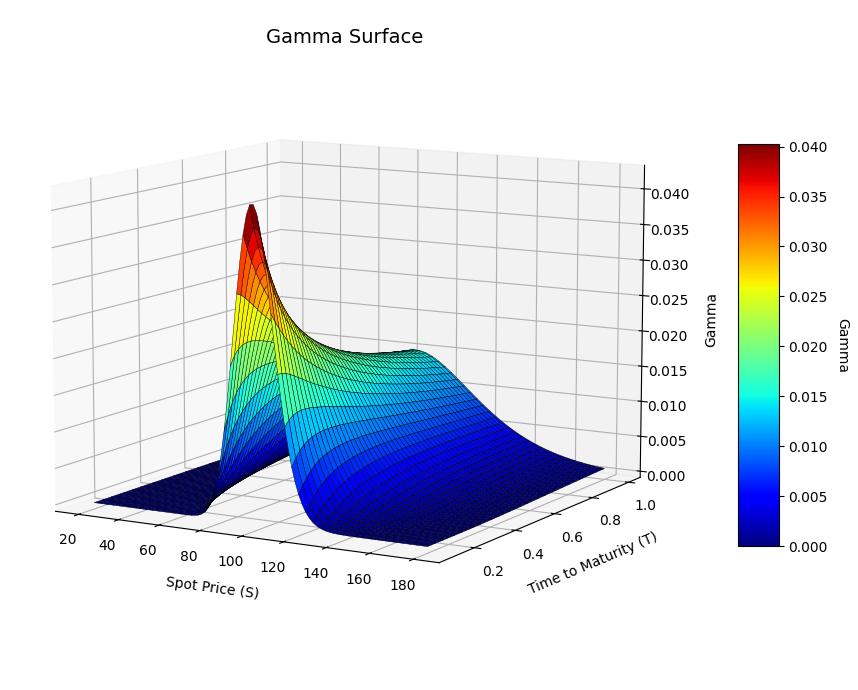

In [8]:
gamma_grid = bs_gamma(S_grid, K, T_grid, r, sigma)
plot_greek_surface(S_grid, T_grid, gamma_grid, "Gamma", azim=300, elev=10)

As time to maturity tend to 0, Gamma forms a **sharp spike at-the-money**, while flattening elsewhere.

This reflects **extreme Delta sensitivity** near expiry, making hedging unstable and costly for **ATM options**.

<a id='vega'></a>
## **1.3 Vega**

- **Definition**: Measures sensitivity of the option price to changes in implied volatility.
- **Formula**:
  $$
  \nu_{call} = \nu_{put} = S \cdot N'(d_1) \cdot \sqrt{T}
  $$
- Used for: Trading volatility (e.g., **IV–RV arbitrage**, event trades).

In [9]:
def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

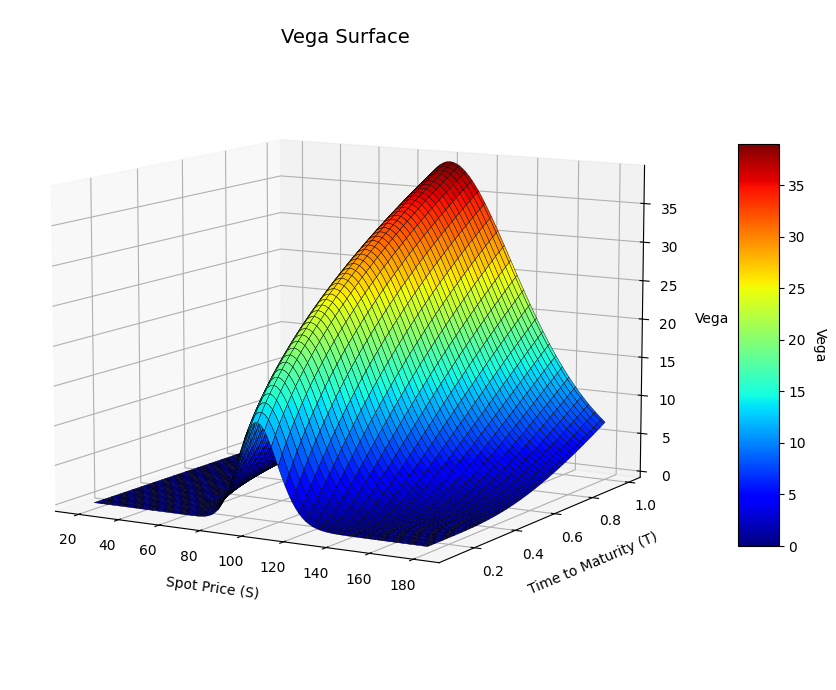

In [10]:
vega_grid = bs_vega(S_grid, K, T_grid, r, sigma)
plot_greek_surface(S_grid, T_grid, vega_grid, "Vega", elev=10, azim=300)

Vega peaks when the option is **at-the-money** and increases with **time to maturity**.

This means long-dated, ATM options are **most sensitive to changes in implied volatility**, while short-dated or deep ITM/OTM options have very low Vega.

<a id='theta'></a>
## **1.4 Theta**

- **Definition**: Measures sensitivity of the option price to the passage of time (time decay).
- **Formula (call)**:
  $$
  \Theta_{ \text{call}} = -\frac{S N'(d_1) \sigma}{2 \sqrt{T}} - rK e^{-rT} N(d_2)
  $$

  $$
  \Theta_{\text{put}} = -\frac{S N'(d_1) \cdot \sigma}{2 \sqrt{T}} + rK e^{-rT} N(-d_2)
  $$
- Used for: Managing **premium decay**, income strategies.

- **Risk:** Long options = negative theta means that everything else equal, we lose time value every day

- **Solutions:**
  - Keep time to expiry short but not too short (10–30 DTE often optimal)
  - Offset with short options elsewhere:
    - E.g., long front-month straddle, short back-month straddle (calendar spread) — called Vega-positive, Theta-neutral structure
  - Enter trades when IV is very low, minimizing theta risk

Realistically, most long-vega trades accept negative theta and time the entry around expected vol events (e.g., earnings, FOMC)

In [11]:
def bs_theta(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    term1 = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))

    if option_type == 'call':
        term2 = - r * K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        term2 = + r * K * np.exp(-r * T) * norm.cdf(-d2)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return term1 + term2

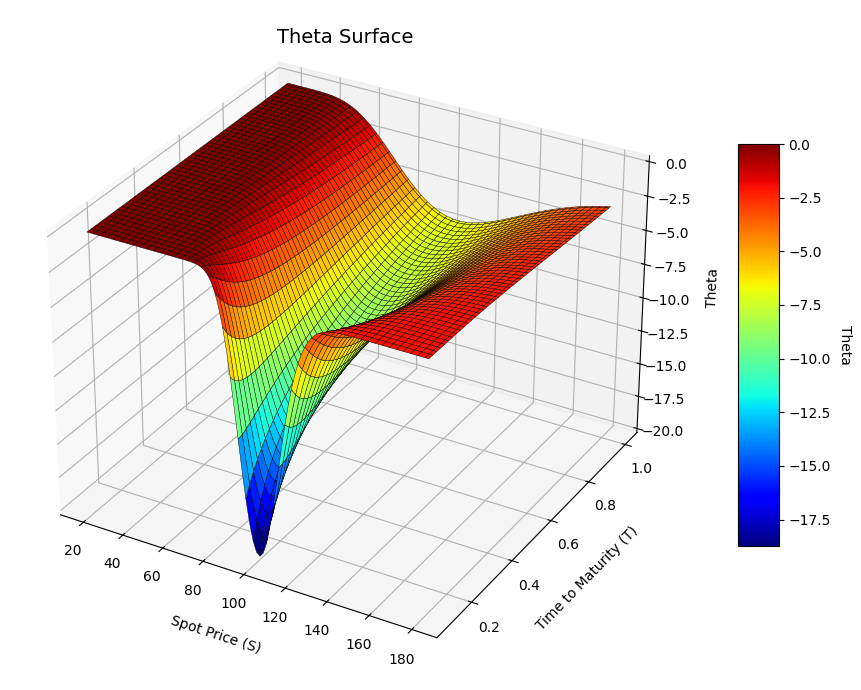

In [12]:
theta_grid = bs_theta(S_grid, K, T_grid, r, sigma)
plot_greek_surface(S_grid, T_grid, theta_grid, "Theta", azim=300)

As time to maturity tend to 0, Theta becomes **increasingly negative**, especially for **at-the-money options**.

This reflects **accelerated time decay** near expiry, a key concern for option sellers managing short-dated positions.

<a id='rho'></a>
## **1.5 Rho**

- **Definition**: Measures sensitivity of the option price to changes in interest rates.
- **Formula (call)**:
$$
\rho_{\text{call}} = K \cdot T \cdot e^{-rT} \cdot N(d_2)
$$

$$
\rho_{\text{put}} = -K \cdot T \cdot e^{-rT} \cdot N(-d_2)
$$

- **Used for**: Long-dated options and rate-sensitive products.

It is the least importnat one because interest rates don't much that much and for retail traders it is very costly to hedge it (dont have access to interest rate instruments like bond futures)

In [13]:
def bs_rho(S, K, T, r, sigma, option_type='call'):
    d2 = (np.log(S / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return K * T * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return -K * T * np.exp(-r * T) * norm.cdf(-d2)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

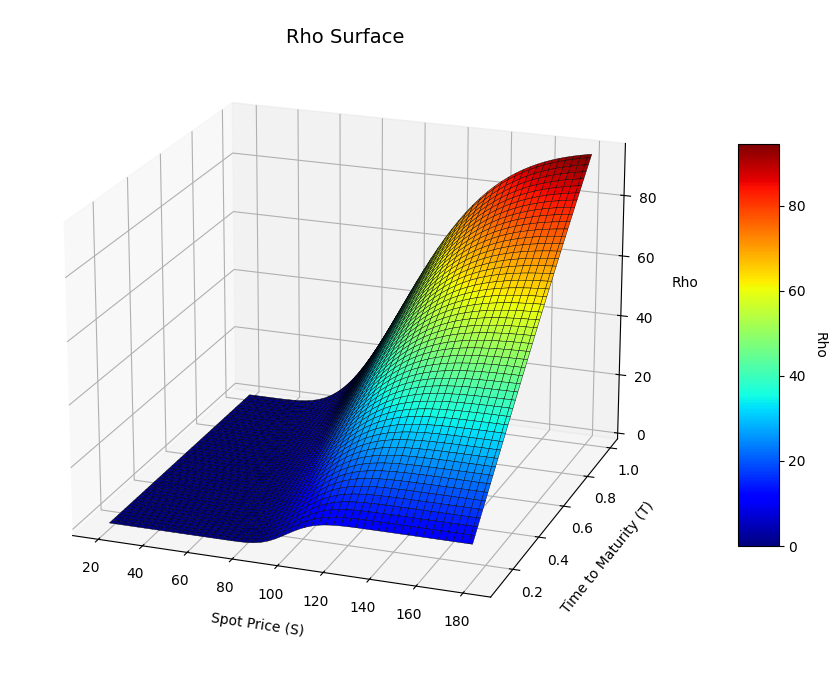

In [14]:
rho_grid = bs_rho(S_grid, K, T_grid, r, sigma)
plot_greek_surface(S_grid, T_grid, rho_grid, "Rho", elev=20, azim=290)

Rho increases with **time to maturity** and is largest when the option is **deep in-the-money**.

Since Rho reflects sensitivity to interest rates, it’s most relevant for **long-dated options** — and often negligible for short-term trades.

---

<a id='hog'></a>
# **2. High-Order Greeks**

Higher-order Greeks capture more nuanced sensitivities in an option's price — often related to changes in volatility, time, or the interaction between primary Greeks.

These are especially relevant for **volatility traders**, **hedge adjustments**, and **long-dated or exotic options**.

<a id='fdm'></a>
## **2.1 Finite Difference Approximations**

In cases where closed-form expressions are unavailable, Greeks can be approximated numerically using finite differences. To show that it works, we can comapre teh delta obtained analytically and the one obtained with the **central difference**

#### Central Difference:

$$
\Delta \approx \frac{V(S + \Delta S) - V(S - \Delta S)}{\Delta S}
$$

$$
\Gamma \approx \frac{V(S + \Delta S) - 2V(S) + V(S - \Delta S)}{(\Delta S)^2}
$$

This estimates Delta as the change in option price for a small increase in the underlying price.

In [15]:
def fdm_delta(bs_price, S, K, T, r, sigma, delta_S=1e-3, option_type="call"):
    return (bs_price(S + delta_S, K, T, r, sigma, option_type) -
            bs_price(S - delta_S, K, T, r, sigma, option_type)) / (2 * delta_S)

def fdm_gamma(bs_price, S, K, T, r, sigma, delta_S=1e-3, option_type='call'):
    return (bs_price(S + delta_S, K, T, r, sigma, option_type) -
            2 * bs_price(S, K, T, r, sigma, option_type) +
            bs_price(S - delta_S, K, T, r, sigma, option_type)) / (delta_S ** 2)

In [16]:
S = 100
T = 1.0

print(f"BS Call Delta: {bs_delta(S, K, T, r, sigma):.4f}")
print(f"FDM Call Delta: {fdm_delta(bs_price, S, K, T, r, sigma):.4f}")

print(f"\nBS Gamma: {bs_gamma(S, K, T, r, sigma):.4f}")
print(f"FDM Gamma: {fdm_gamma(bs_price, S, K, T, r, sigma):.4f}")

BS Call Delta: 0.5858
FDM Call Delta: 0.5858

BS Gamma: 0.0130
FDM Gamma: 0.0130


<a id='vanna'></a>
## **2.2 Vanna**

- **Definition**: Measures the sensitivity of Delta with respect to changes in volatility.

$$
\text{Vanna} = \frac{\partial^2 V}{\partial S \, \partial \sigma} = \frac{\partial \Delta}{\partial \sigma} = \frac{\partial \nu}{\partial S}
$$

$$
\text{Vanna} \approx 
\frac{
\Delta_{BS}(\sigma + \epsilon) 
- \Delta_{BS}(\sigma - \epsilon)
}{
2 \epsilon
}
=
\frac{
\nu_{BS}(S + h) 
- \nu_{BS}(S - h)
}{
2 h
}
$$

Vanna helps explain how the volatility surface shifts as spot moves, and it’s closely tied to implied volatility skew. Traders may take positions with positive or negative Vanna to profit from skew dynamics.

In [17]:
def fdm_vanna(bs_delta, S, K, T, r, sigma, delta_sigma=1e-3):
    return (bs_delta(S, K, T, r, sigma + delta_sigma) -
            bs_delta(S, K, T, r, sigma - delta_sigma)) / (2 * delta_sigma)

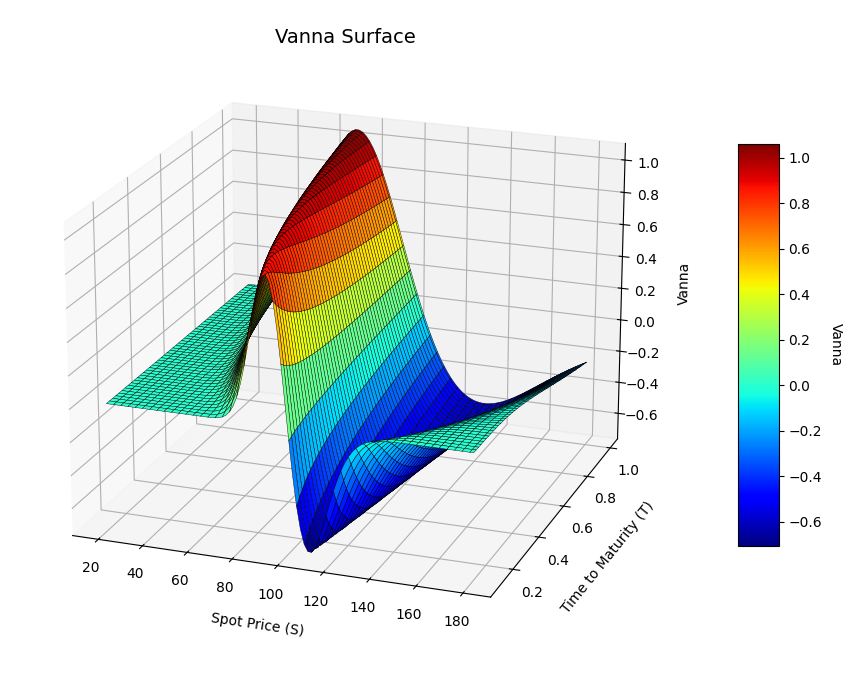

In [18]:
vanna_grid = fdm_vanna(bs_delta, S_grid, K, T_grid, r, sigma)
plot_greek_surface(S_grid, T_grid, vanna_grid, "Vanna", elev=20, azim=290)

Vanna is **near zero at-the-money**, and reaches positive and negative extrema just inside and outside the money, reflecting the sensitivity of delta to volatility across moneyness.

<a id='volga'></a>
## **2.3 Volga (Vomma)**

- **Definition**: Measures the sensitivity of Vega with respect to changes in volatility.

$$
\text{Volga} = \frac{\partial^2 V}{\partial \sigma^2} = \frac{\partial \nu}{\partial \sigma}
$$

Volga helps explain how an option’s Vega changes as volatility changes, and it’s closely tied to the convexity of implied volatility. Traders may take positions with positive or negative Volga to profit from large volatility moves or shifts in the shape of the volatility surface.

In [19]:
def fdm_volga(bs_vega, S, K, T, r, sigma, delta_sigma=1e-3):
    return (bs_vega(S, K, T, r, sigma + delta_sigma) -
            bs_vega(S, K, T, r, sigma - delta_sigma)) / (2 * delta_sigma)

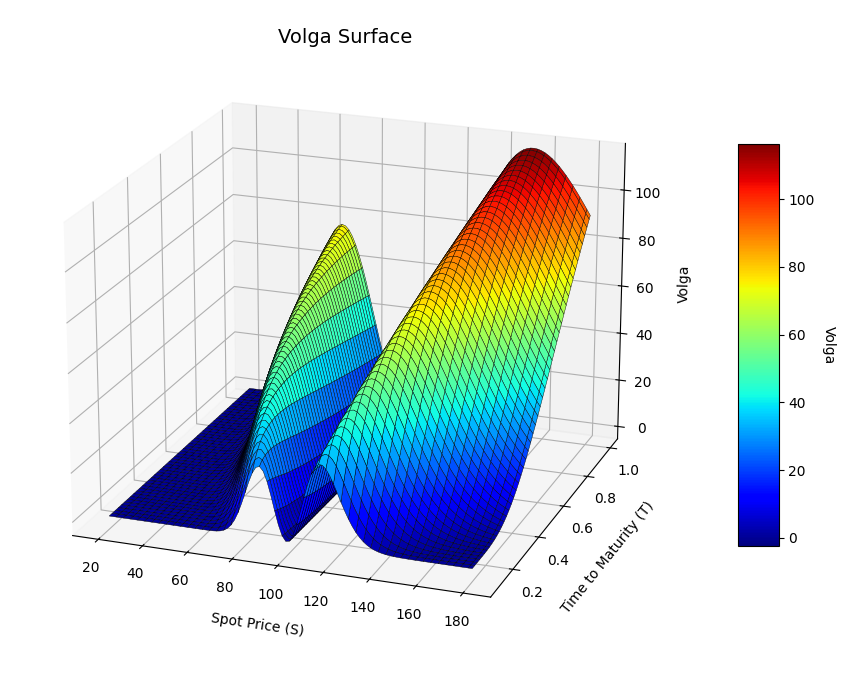

In [20]:
volga_grid = fdm_volga(bs_vega, S_grid, K, T_grid, r, sigma)
plot_greek_surface(S_grid, T_grid, volga_grid, "Volga", elev=20, azim=290)

Here we can see that the effect on the vega is more pronounced when we are slitghly in and out of the money as arround those levels the options have a higher probabiliy to end up out and in the money respectively. However ATM options have a close to zero **volga** as the **vega** is already at its highest so a large increase in IV does not change the value of vega.

**Trading vol takeaway:** If you hold vega (e.g. long options) and you expect vol to rise, positive volga means your vega will increase, giving you even more upside to higher vol.

<a id='charm'></a>
## **2.4 Charm**

- **Definition**: Measures the sensitivity of Delta with respect to the passage of time.

$$
\text{Charm} = - \frac{\partial \Delta}{\partial T}
$$

Charm reflects how the passage of time erodes an option’s directional sensitivity, and is especially important for delta-hedged portfolios. Traders monitor Charm to anticipate how their hedge ratios will drift as expiration approaches.

In [21]:
def fdm_charm(bs_delta, S, K, T, r, sigma, delta_t=-1e-3):
    return - (bs_delta(S, K, T + delta_t, r, sigma) -
            bs_delta(S, K, T - delta_t, r, sigma)) / (2 * delta_t)

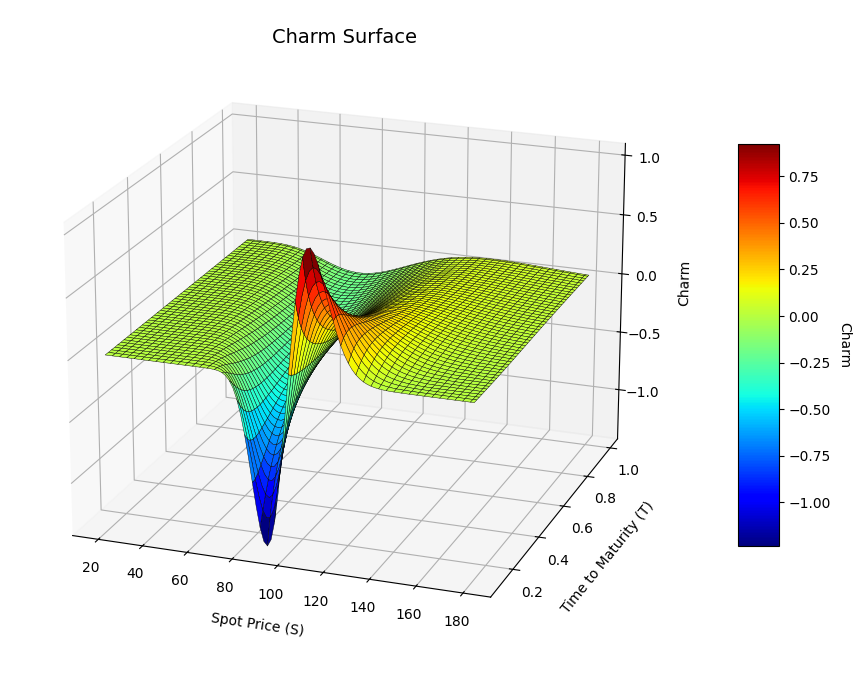

In [22]:
charm_grid = fdm_charm(bs_delta, S_grid, K, T_grid, r, sigma)
plot_greek_surface(S_grid, T_grid, charm_grid, "Charm", elev=20, azim=290)

- For **in-the-money** options, charm is typically positive because as each day passes, the probability of finishing in the money increases, which tends to stabilize or increase the delta.

- For **out-of-the-money** options, charm is usually negative, since the likelihood of expiring in the money decreases with time, causing delta to decay.

- For **at-the-money** options, charm is often unstable or highly variable, because as time to maturity decreases, small movements in the underlying can cause delta to shift rapidly toward 1 or 0.